 # 315 Bird Species - Classification using Transfer Learning
 <img src="http://images.unsplash.com/photo-1444465693019-aa0b6392460d?ixlib=rb-1.2.1&q=80&fm=jpg&crop=entropy&cs=tinysrgb&w=1080&fit=max" style="max-width:480px">


In [4]:
project_name="315 Bird Species - Classification"

In [6]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Downloading Dataset from Kaggle

In [7]:
!pip install opendatasets --quiet

In [8]:
# Deleting dataset if previously exist
import shutil,os
if os.path.exists('./100-bird-species'):
  shutil.rmtree('./100-bird-species')

In [9]:
import opendatasets as od
dataset_url = "https://www.kaggle.com/gpiosenka/100-bird-species?select=valid"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: srsomu
Your Kaggle Key: ··········


100%|██████████| 1.14G/1.14G [00:06<00:00, 200MB/s]


In [10]:
# Looking into the data directory
data_dir = './100-bird-species'
print(os.listdir(data_dir))

['valid', 'train', 'class_dict.csv', 'one image to test', 'test', 'images to test', 'EfficientNetB3-birds-98.92.h5']


In [11]:
# Delete a unnecessary Directory and Files
import shutil
for i in ['images to test', 'one image to test']:
    shutil.rmtree(data_dir+'/'+i)
    
# Delete a file
for i in ['/EfficientNetB3-birds-98.92.h5','/class_dict.csv']:
    os.remove(data_dir+i)

In [12]:
# Checking number of images each class consists 
for cls in os.listdir(data_dir+'/train'):
  print(cls, ':' ,len(os.listdir(data_dir+'/train'+'/'+cls)))

GUINEAFOWL : 138
COMMON HOUSE MARTIN : 127
MALAGASY WHITE EYE : 143
BLUE HERON : 167
ENGGANO MYNA : 124
OSTRICH : 123
BORNEAN LEAFBIRD : 120
MANDRIN DUCK : 130
VENEZUELIAN TROUPIAL : 127
GREY PLOVER : 120
PALILA : 120
SAMATRAN THRUSH : 128
BROWN CREPPER : 177
SRI LANKA BLUE MAGPIE : 161
SORA : 200
KOOKABURRA : 143
BALI STARLING : 132
PARADISE TANAGER : 176
PURPLE SWAMPHEN : 154
MYNA : 141
INDIAN PITTA : 186
LARK BUNTING : 120
SMITHS LONGSPUR : 120
COMMON LOON : 120
BLUE COAU : 145
OCELLATED TURKEY : 120
BLACK TAIL CRAKE : 149
BLUE GROUSE : 185
BOBOLINK : 157
COMMON FIRECREST : 139
CRESTED NUTHATCH : 152
SCARLET MACAW : 120
COLLARED ARACARI : 177
STRAWBERRY FINCH : 167
RED BEARDED BEE EATER : 197
DOWNY WOODPECKER : 127
CHIPPING SPARROW : 120
RED HEADED WOODPECKER : 133
PUFFIN : 124
CALIFORNIA GULL : 120
ANNAS HUMMINGBIRD : 139
ASIAN CRESTED IBIS : 157
BLONDE CRESTED WOODPECKER : 144
INCA TERN : 119
RED TAILED THRUSH : 130
CANARY : 160
SHORT BILLED DOWITCHER : 164
BAY-BREASTED WARBLER : 

In [13]:
# Listing out number of classes available in our dataset
classes = os.listdir(data_dir + "/train")
classes.sort()

In [14]:
len(classes)

315

# Import Dataset into PyTorch 

In [15]:
from torchvision.datasets import ImageFolder
train_dataset=ImageFolder(data_dir+'/train')

In [16]:
train_dataset[852]

(<PIL.Image.Image image mode=RGB size=224x224 at 0x7FA1FA3F6190>, 5)

AFRICAN FIREFINCH
(224, 224)


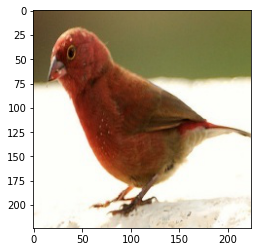

In [17]:
img,label=train_dataset[160]
plt.imshow(img)
print(classes[label])
print(img.size)

In [18]:
# # Data transforms (normalization & data augmentation)

# import torchvision.transforms as tt
# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
# train_tfms = tt.Compose([tt.Resize(224),
#                          tt.RandomCrop(224, padding=4, padding_mode='reflect'), 
#                          tt.RandomHorizontalFlip(), 
#                          tt.ToTensor(), 
#                          tt.Normalize(*stats,inplace=True)])
# valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])
# ttss=valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [19]:
# Simply Resizing and tranformaing our Tensors
import torchvision.transforms as tt
train_tfms = tt.Compose([tt.Resize(224),
                         tt.ToTensor()])
valid_tfms = tt.Compose([tt.ToTensor()])

In [20]:
# PyTorch datasets
from torchvision.datasets import ImageFolder
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/valid', valid_tfms)

In [21]:
len(train_ds)

45980

In [22]:
len(valid_ds)

1575

In [23]:
# # Denormailizing our normalized image tensor for plotting
# def denormalize(images, means, stds):
#     means = torch.tensor(means).reshape(1, 3, 1, 1)
#     stds = torch.tensor(stds).reshape(1, 3, 1, 1)
#     return images * stds + means

# def show_example(img, label):
#     denorm_images = denormalize(img, *stats)
#     print('Label: ', train_dataset.classes[label], "("+str(label)+")")
#     plt.imshow(denorm_images[0].permute(1, 2, 0))
#     print(denorm_images[0].shape)

In [24]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  AMERICAN PIPIT (9)


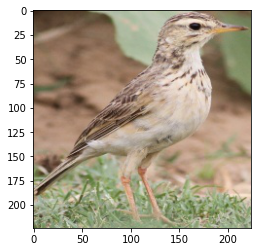

In [25]:
show_example(*train_ds[1387])

# PyTorch DataLoaders
##### We are taking small batches of data to prevent from out of memory error 

In [26]:

from torch.utils.data import DataLoader

batch_size=20
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, 30, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Make Grid

In [27]:
from torchvision.utils import make_grid
# # Make Grid from Normalized images

# def denormalize(images, means, stds):
#     means = torch.tensor(means).reshape(1, 3, 1, 1)
#     stds = torch.tensor(stds).reshape(1, 3, 1, 1)
#     return images * stds + means

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 12))    # Figure size and Subplot
#         ax.set_xticks([]); ax.set_yticks([])
#         denorm_images = denormalize(images, *stats)
#         ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0));
#         break

In [28]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))    # Figure size and Subplot
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0));
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


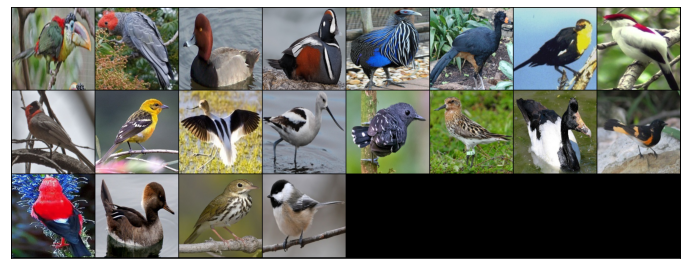

In [29]:
show_batch(train_dl)

## Using GPU/CPU
#### Moving Our Dataset to available device

In [30]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device() 
device



device(type='cuda')

In [31]:
  
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


## Modifying a Pretrained Model (ResNet34)

Transfer learning ([source](https://mc.ai/transfer-learning-with-deep-learning-machine-learning-techniques/)):
![transfer-learning](https://miro.medium.com/max/1000/1*LUFUl_8fqS97nUzpcFjgWw.png)

In [33]:

import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))

In [34]:
from torchvision import models
models.resnet34(pretrained=True)  # Resnet34 as it as 34 training layers ( 33 convolution layers and 1 linear layer ) 
# and here we customize the 1 predefined linear layer as per our requires classes

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
from torchvision import models
class BirdsClassifier(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)   # replacing last part i.e fc and taking its input features(512) and instead of 1000 out_features we use 37 out_features

    def forward(self, xb):
        return self.network(xb)

# Training the model

In [36]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

#### Moving model to available device

In [37]:
model = BirdsClassifier(len(classes))
to_device(model, device);

#### Random check using training dataset

In [38]:
for batch in train_dl:
  img,lab=batch
  print(img.shape)
  print(img.device)
  preds=model(img)
  print(preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([20, 3, 224, 224])
cuda:0
torch.Size([20, 315])


In [39]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.008805031888186932, 'val_loss': 6.049596309661865}]

In [40]:
epochs = 10
max_lr = 0.008
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [41]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/2299 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0],last_lr: 0.00224, train_loss: 2.2038, val_loss: 1.7507, val_acc: 0.5748


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00608, train_loss: 1.8162, val_loss: 1.6255, val_acc: 0.5805


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00800, train_loss: 1.6509, val_loss: 1.7603, val_acc: 0.5591


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00760, train_loss: 1.4429, val_loss: 1.1697, val_acc: 0.6899


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00649, train_loss: 1.2452, val_loss: 0.9447, val_acc: 0.7516


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00489, train_loss: 1.0351, val_loss: 0.5992, val_acc: 0.8409


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00311, train_loss: 0.8010, val_loss: 0.4252, val_acc: 0.8805


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00151, train_loss: 0.5353, val_loss: 0.2587, val_acc: 0.9289


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00040, train_loss: 0.3008, val_loss: 0.1700, val_acc: 0.9522


  0%|          | 0/2299 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00000, train_loss: 0.1597, val_loss: 0.1551, val_acc: 0.9553
CPU times: user 1h 8min 6s, sys: 38min 12s, total: 1h 46min 19s
Wall time: 1h 47min 25s


### PLot of Training loss vs Validation loss

In [64]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

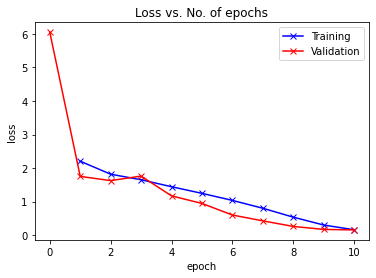

In [65]:
plot_losses(history)

### Plot depicting how learning rate varying over epoch*batches ( 8 * (45980/20) )

In [66]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

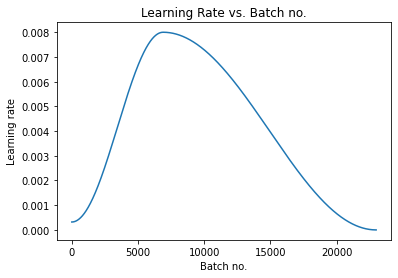

In [67]:
plot_lrs(history)

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset.


In [68]:
test_dataset = ImageFolder(data_dir+'/test', transform=tt.ToTensor())

In [69]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    print(preds)
    return train_ds.classes[preds[0].item()]

tensor([0], device='cuda:0')
Label: AFRICAN CROWNED CRANE , Predicted: AFRICAN CROWNED CRANE


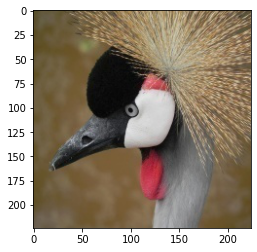

In [72]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))

tensor([32], device='cuda:0')
Label: BIRD OF PARADISE , Predicted: BIRD OF PARADISE


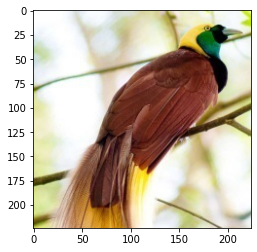

In [71]:
img, label = valid_ds[164]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))

tensor([30], device='cuda:0')
Label: BEARDED REEDLING , Predicted: BEARDED REEDLING


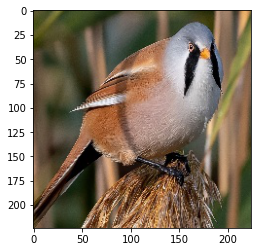

In [73]:
img, label = test_dataset[154]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))